Scoresheet handwriting quiz: plots and regressions
==========================================

_Chuan-Zheng Lee <czlee@stanford.edu>_

This notebook accompanies [this Medium post summarizing some results](https://medium.com/@czlee/no-you-cant-read-a-debate-scoresheet-2b7c2239d091) from [this quiz](https://docs.google.com/forms/d/e/1FAIpQLSeohVm7cjg7zavMiYmI-RqpiWEuTQBNwpcIAKTHrCE2De-k5w/viewform?usp=sf_link) asking respondents to decipher some numbers that were on scoresheet at the 2018 United States Universities Debating Championships. There's also [this Google spreadsheet](https://docs.google.com/spreadsheets/d/1TUgPou6ZvyGr_xdj2Wpj5BZuJOs7buNwk_D5rcYkthU/edit?usp=sharing) with some similar statistics in a different format.

If you want to run this notebook, you'll need the dataset "quizresults.csv", which isn't in this repository. To find it, go to [the Google spreadsheet](https://docs.google.com/spreadsheets/d/1TUgPou6ZvyGr_xdj2Wpj5BZuJOs7buNwk_D5rcYkthU/edit?usp=sharing), open the "Export to quizresults.csv" sheet, download it as a CSV file (_File_ > _Download as…_ > _Comma-separated values (.csv, current sheet)_), and save it as "quizresults.csv" in the same directory as this notebook.

Many thanks to Emma Pierson for giving me a primer on how to do basic statistical regression using `statsmodels` in Python.

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, OffsetImage
from patsy import Treatment
from PIL import Image as PILImage
from IPython.display import display

In [2]:
df = pd.read_csv('quizresults.csv')
pd.set_option('precision', 3)
mpl.rc('font', family='DejaVu Serif', size=14)
questions = list('abcdefghij')
answers = [4, 5, 9, 5, 9, 6, 9, 5, 5, 4]

## Overall score and answer key

In [3]:
df['score'].count()

2121

In [4]:
df['score'].mean()

4.2437529467232435

[7, 51, 207, 409, 510, 524, 275, 109, 27, 0, 2]

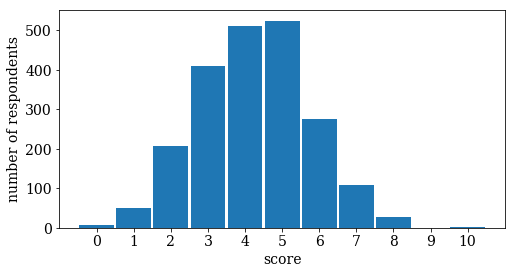

In [5]:
counts = df['score'].value_counts().sort_index()
x = range(0, 11)
counts = [counts.get(i, 0) for i in x]
fig = plt.figure(figsize=(8,4))
plt.bar(x, counts, tick_label=x, width=0.94)
plt.xlabel('score')
plt.ylabel('number of respondents')
fig.savefig('overall-hist.png')
counts

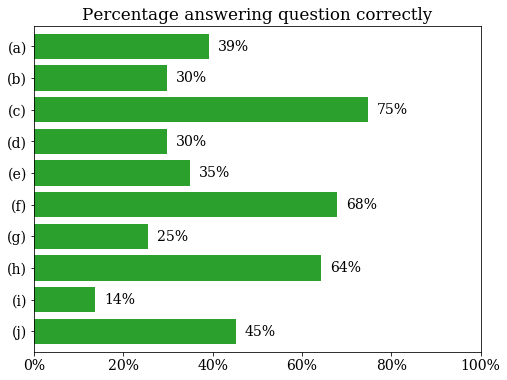

In [6]:
correct_columns = ['%s_correct' % q for q in questions]
means = df[correct_columns].mean()
plt.figure(figsize=(8,6))
means.plot(kind='barh', xlim=(0,1), width=0.8, color='C2')
plt.xticks([i*0.1 for i in range(0,11,2)], ['%d%%' % (x*10) for x in range(0,11,2)])
ax = plt.gca()
ax.invert_yaxis()
ax.set_yticklabels(['(%s)' % q for q in questions])
for i, m in enumerate(means):
    ax.text(m+0.02, i, "%.0f%%" % (m*100), va='center')
plt.title("Percentage answering question correctly");

## Answer pie charts

In [7]:
SUBPLOT_WIDTH = 5.75

In [8]:
def answer_pie(ax, df, question):
    """Plots a pie chart of responses in the given dataframe `df`, for
    the given `question`, and superimposes the question image in the
    lower right corner."""
    
    counts = df['%s_answer' % question].value_counts().sort_index()
    x = range(0, 11)
    counts = [counts.get(i, 0) for i in x]
    
    patches, texts, autotexts = ax.pie(counts, labels=x, startangle=90, 
            counterclock=False, autopct='%.0f%%', pctdistance=0.7)

    ax.set_title('answers to (%s)' % question)
    ax.axis('square')
    
    # remove labels for negligible slices
    for text, autotext in zip(texts, autotexts):
        if autotext.get_text()[0] == '0':
            autotext.set_text('')
            text.set_text('')
    
    # mark the correct answer
    correct = answers[questions.index(question)]
    texts[correct].set_text("%d (√)" % correct)
    
    # draw the question image
    im = PILImage.open('images/%s.jpg' % question)
    im.thumbnail((80,80), PILImage.LANCZOS)
    imbox = OffsetImage(im)
    oab = AnchoredOffsetbox('lower right', child=imbox, pad=0, frameon=False)
    ax.add_artist(oab)

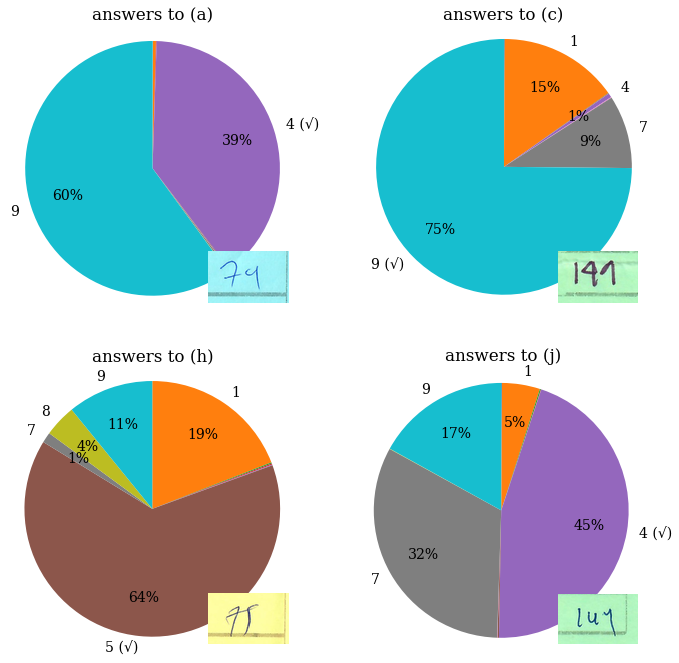

In [9]:
# Contentious questions
fig, axs = plt.subplots(2, 2, figsize=(2*SUBPLOT_WIDTH, 2*SUBPLOT_WIDTH))
for ax, q in zip(axs.flatten(), 'achj'):
    answer_pie(ax, df, q)
fig.savefig('contentious.png', bbox_inches='tight')

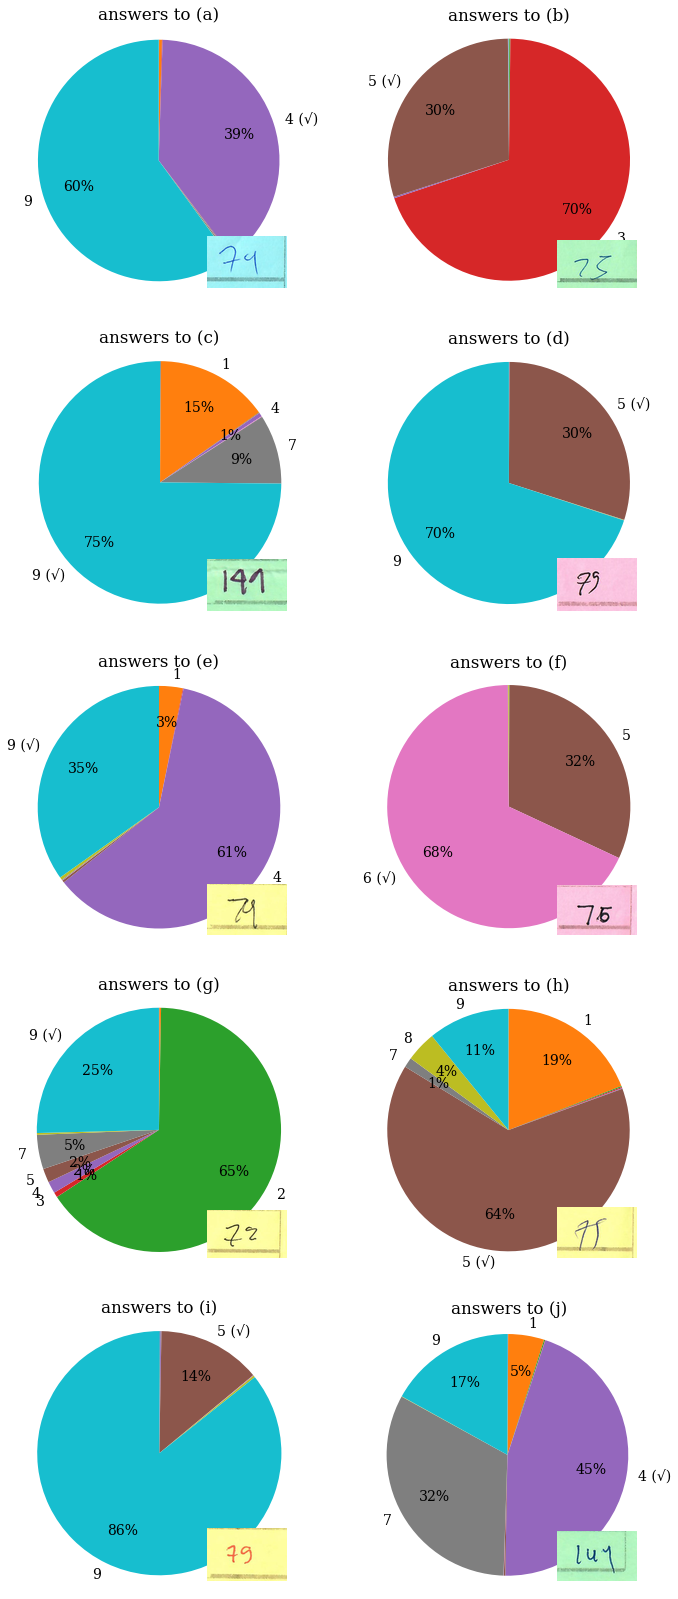

In [10]:
# All questions
fig, axs = plt.subplots(5, 2, figsize=(2*SUBPLOT_WIDTH, 5*SUBPLOT_WIDTH))
for ax, q in zip(axs.flatten(), questions):
    answer_pie(ax, df, q)

## Responses to particular questions by region

In [11]:
def answer_pie_for_query(ax, query, question, title):
    """Plots a pie chart for responses to the given `question`, among those
    responses satisfying the given `query`, and adds the given `title` to
    the plot title."""
    sub_df = df[query]
    answer_pie(ax, sub_df, question)
    n = sub_df.count()[0]
    ax.set_title("answers to (%s)\n%s (n = %d)" % (question, title, n))

### Image (c), for continental Europe

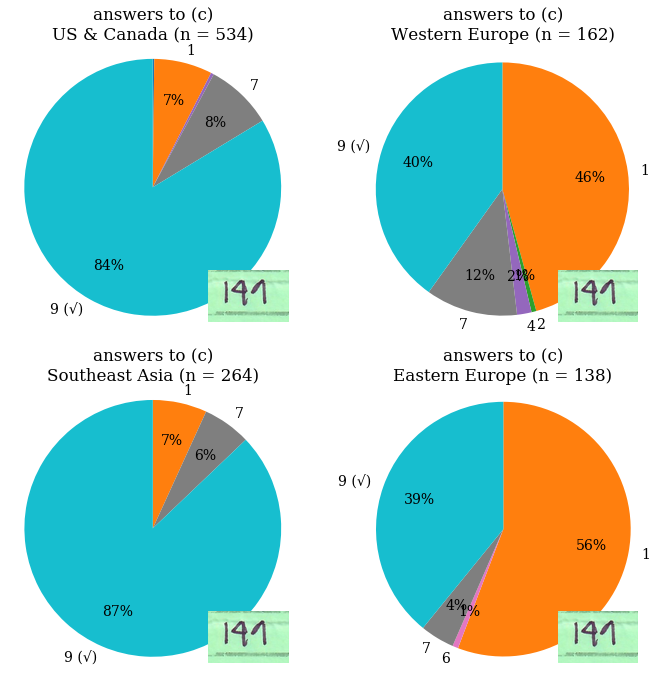

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(2*SUBPLOT_WIDTH, 2*SUBPLOT_WIDTH))
regions = ['US & Canada', 'Western Europe', 'Southeast Asia', 'Eastern Europe']
for ax, region in zip(axs.flatten(), regions):
    answer_pie_for_query(ax, df.region == region, 'c', region)

It's a bit more succinct just to compare "continental Europe" to "everyone else".

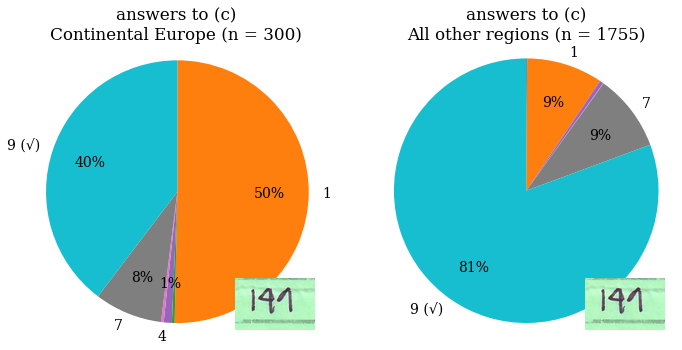

In [13]:
df['europe'] = df.region.isin(['Western Europe', 'Eastern Europe'])

fig, axs = plt.subplots(1, 2, figsize=(2*SUBPLOT_WIDTH, SUBPLOT_WIDTH), squeeze=True)
answer_pie_for_query(axs[0], df.europe, 'c', 'Continental Europe')
answer_pie_for_query(axs[1], ~df.europe, 'c', 'All other regions')
fig.savefig('c-europe.png', bbox_inches='tight')

I didn't cite significance measures in the post, because for this one it's pretty obvious. But for what it's worth, under logistic regression on the answer being correct, we're looking at a $p$-value of less than $10^{-44}$.

In [14]:
model = sm.Logit.from_formula('c_correct ~ europe', data=df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.516812
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              c_correct   No. Observations:                 2119
Model:                          Logit   Df Residuals:                     2117
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                 0.08369
Time:                        16:58:08   Log-Likelihood:                -1095.1
converged:                       True   LL-Null:                       -1195.1
                                        LLR p-value:                 2.043e-45
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4273      0.059     24.049      0.000       1.311       1.544
europe[T.True]    -1.8467      0.132    -13.980      0.000      -2.106      -1.588
==================================================================================
"""

### Image (h), for East Asia

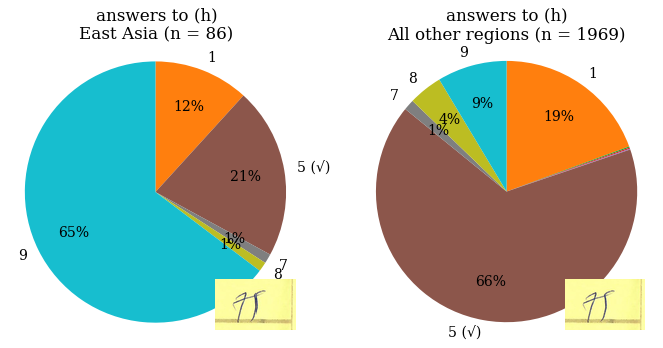

In [15]:
df['east_asia'] = df.region == 'East Asia'

fig, axs = plt.subplots(1, 2, figsize=(2*SUBPLOT_WIDTH, SUBPLOT_WIDTH), squeeze=True)
answer_pie_for_query(axs[0], df.east_asia, 'h', 'East Asia')
answer_pie_for_query(axs[1], ~df.east_asia, 'h', 'All other regions')
fig.savefig('h-eastasia.png', bbox_inches='tight')

In [16]:
model = sm.Logit.from_formula('h_correct ~ east_asia', data=df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.635436
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              h_correct   No. Observations:                 2117
Model:                          Logit   Df Residuals:                     2115
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                 0.02501
Time:                        16:58:09   Log-Likelihood:                -1345.2
converged:                       True   LL-Null:                       -1379.7
                                        LLR p-value:                 9.755e-17
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6674      0.047     14.242      0.000       0.576       0.759
east_asia[T.True]    -1.9817      0.270     -7.351      0.000      -2.510      -1.453
=====================================================================================
"""

### Image (a), for US & Canada, and Oceania

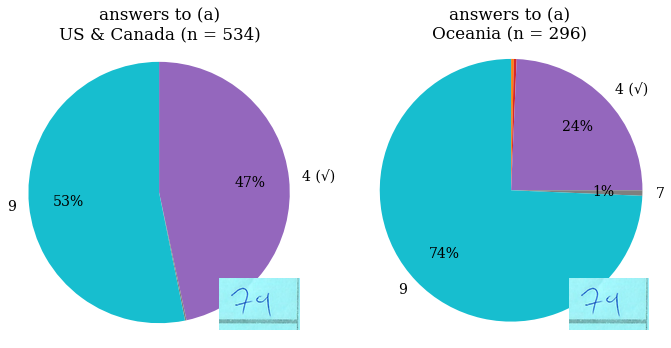

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(2*SUBPLOT_WIDTH, SUBPLOT_WIDTH), squeeze=True)
answer_pie_for_query(axs[0], df.region == 'US & Canada', 'a', 'US & Canada')
answer_pie_for_query(axs[1], df.region == 'Oceania', 'a', 'Oceania')

In [18]:
df_uscanada_oceania = df[df.region.isin(['US & Canada', 'Oceania'])]
model = sm.Logit.from_formula('a_correct ~ region', data=df_uscanada_oceania).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.642342
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              a_correct   No. Observations:                  830
Model:                          Logit   Df Residuals:                      828
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                 0.03736
Time:                        16:58:09   Log-Likelihood:                -533.14
converged:                       True   LL-Null:                       -553.83
                                        LLR p-value:                 1.252e-10
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.1350      0.135     -8.378      0.000      -1.401      -0.869
region[T.US & Canada]     0.9999      0.161      6.216      0.000       0.685       1.315
=========================================================================================
"""

### Image (d), for Germany and the Netherlands

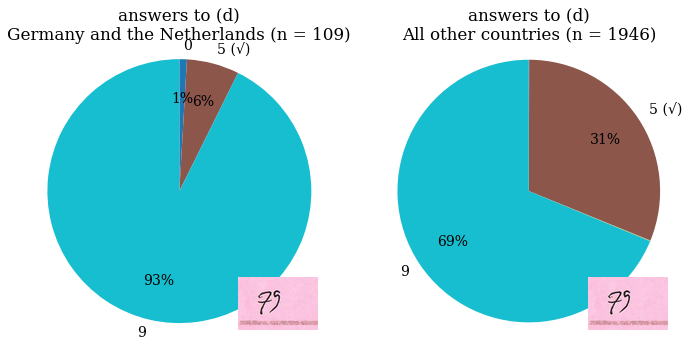

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(2*SUBPLOT_WIDTH, SUBPLOT_WIDTH), squeeze=True)
answer_pie_for_query(axs[0], df.country.isin(['Germany', 'Netherlands']), 'd', 'Germany and the Netherlands')
answer_pie_for_query(axs[1], ~df.country.isin(['Germany', 'Netherlands']), 'd', 'All other countries')

In [20]:
model = sm.Logit.from_formula('d_correct ~ (country == "Germany") + (country == "Netherlands")', data=df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.600009
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              d_correct   No. Observations:                 2119
Model:                          Logit   Df Residuals:                     2116
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                 0.01537
Time:                        16:58:09   Log-Likelihood:                -1271.4
converged:                       True   LL-Null:                       -1291.3
                                        LLR p-value:                 2.392e-09
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.7957      0.048    -16.513      0.000      -0.890      -0.701
country == "Germany"[T.True]        -2.2488      0.593     -3.793      0.000      -3.411      -1.087
country == "Netherlands"[T.True]    -1.4816      0.527     -2.810      0.005      -2.515      -0.448
====================================================================================================
"""

## Average score by country or region

In [21]:
def categories_chart(ax, data, color=None):
    """Plots a horizontal bar chart using the given `data`, which 
    should be a list of `(country, mean, (upper, lower), nobs)`
    tuples. `color` is passed to matplotlib."""
    
    data.sort(key=lambda x: x[1], reverse=True)
    categories, means, confints, ns = zip(*data)
    errors = [[], []]
    for mean, (lower, upper) in zip(means, confints):
        errors[0].append(mean - lower)
        errors[1].append(upper - mean)
    ax.barh(categories, means, xerr=errors, color=color)
    ax.set_xlim((0, 6))
    ax.set_axisbelow(True)
    ax.xaxis.grid()
    ax.invert_yaxis()
    for i, (mean, n) in enumerate(zip(means, ns)):
        ax.text(mean-1, i, "%.2f" % mean, va='center', ha='right', color='white')
        ax.text(5.9, i, str(int(n)), va='center', ha='right')

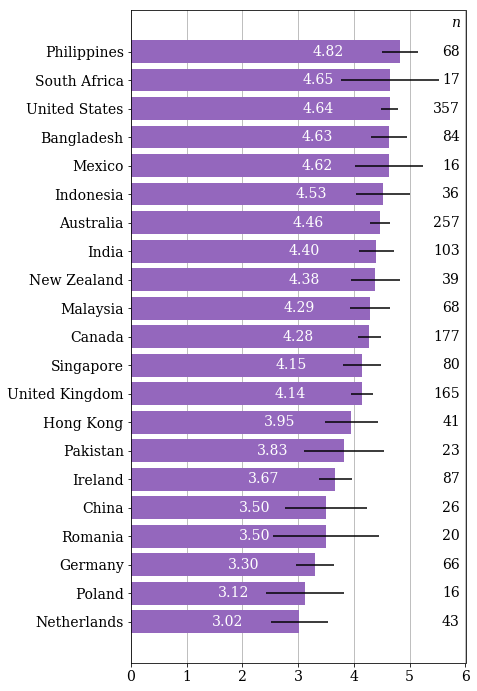

In [22]:
data = []
for country in df.country.unique():
    if df[df.country == country]['score'].count() < 15:
        continue
    stats = sms.DescrStatsW(df[df.country == country]['score'])
    if country == 'Hong Kong SAR China':
        country = 'Hong Kong'  # save space
    data.append((country, stats.mean, stats.tconfint_mean(), stats.nobs))

fig = plt.figure(figsize=(6,12))
ax = fig.gca()
categories_chart(ax, data, 'C4')
ax.text(5.9, -1, 'n', style='italic', va='center', ha='right')
fig.savefig('country.png', bbox_inches='tight')

In [23]:
countries = df.country.value_counts()[df.country.value_counts() >= 15].index.tolist()
treat_us = Treatment(reference="United States")  # make United States the base category
model = sm.OLS.from_formula('score ~ C(country, treat_us)', 
                            data=df[df.country.isin(countries)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     7.564
Date:                Thu, 21 Jun 2018   Prob (F-statistic):           3.84e-21
Time:                        16:58:10   Log-Likelihood:                -3200.1
No. Observations:                1789   AIC:                             6442.
Df Residuals:                    1768   BIC:                             6557.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       4.6415      0.077     60.231      0.000       4.490       4.793
C(country, treat_us)[T.Australia]              -0.1784      0.119     -1.498      0.134      -0.412       0.055
C(country, treat_us)[T.Bangladesh]             -0.0105      0.177     -0.059      0.953      -0.357       0.336
C(country, treat_us)[T.Canada]                 -0.3646      0.134     -2.724      0.007      -0.627      -0.102
C(country, treat_us)[T.China]                  -1.1415      0.296     -3.859      0.000      -1.722      -0.561
C(country, treat_us)[T.Germany]                -1.3384      0.195     -6.861      0.000      -1.721      -0.956
C(country, treat_us)[T.Hong Kong SAR China]    -0.6902      0.240     -2.875      0.004      -1.161      -0.219
C(country, treat_us)[T.India]                  -0.2434      0.163     -1.495      0.135      -0.563       0.076
C(country, treat_us)[T.Indonesia]              -0.1137      0.255     -0.446      0.655      -0.613       0.386
C(country, treat_us)[T.Ireland]                -0.9748      0.174     -5.599      0.000      -1.316      -0.633
C(country, treat_us)[T.Malaysia]               -0.3473      0.193     -1.803      0.072      -0.725       0.031
C(country, treat_us)[T.Mexico]                 -0.0165      0.372     -0.044      0.965      -0.746       0.713
C(country, treat_us)[T.Netherlands]            -1.6182      0.235     -6.885      0.000      -2.079      -1.157
C(country, treat_us)[T.New Zealand]            -0.2568      0.246     -1.046      0.296      -0.738       0.225
C(country, treat_us)[T.Pakistan]               -0.8154      0.313     -2.603      0.009      -1.430      -0.201
C(country, treat_us)[T.Philippines]             0.1821      0.193      0.945      0.345      -0.196       0.560
C(country, treat_us)[T.Poland]                 -1.5165      0.372     -4.076      0.000      -2.246      -0.787
C(country, treat_us)[T.Romania]                -1.1415      0.335     -3.412      0.001      -1.798      -0.485
C(country, treat_us)[T.Singapore]              -0.4915      0.180     -2.729      0.006      -0.845      -0.138
C(country, treat_us)[T.South Africa]            0.0056      0.361      0.015      0.988      -0.703       0.715
C(country, treat_us)[T.United Kingdom]         -0.5021      0.137     -3.663      0.000      -0.771      -0.233
==============================================================================
Omnibus:                        2.743   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.693
Skew:                           0.094   Prob(JB):                        0.260
Kurtosis:                       3.022   Cond. No.                         13.2


In [24]:
# Checking that all these countries have only statistically insignificant differences with the US
countries = ['Philippines', 'South Africa', 'United States', 'Bangladesh', 
             'Mexico', 'Indonesia', 'Australia', 'India', 'New Zealand', 'Malaysia']
model = sm.OLS.from_formula('score ~ C(country, treat_us)',
                            data=df[df.country.isin(countries)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9781
Date:                Thu, 21 Jun 2018   Prob (F-statistic):              0.456
Time:                        16:58:10   Log-Likelihood:                -1872.3
No. Observations:                1045   AIC:                             3765.
Df Residuals:                    1035   BIC:                             3814.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                4.6415      0.077     60.123      0.000       4.490       4.793
C(country, treat_us)[T.Australia]       -0.1784      0.119     -1.495      0.135      -0.413       0.056
C(country, treat_us)[T.Bangladesh]      -0.0105      0.177     -0.059      0.953      -0.358       0.337
C(country, treat_us)[T.India]           -0.2434      0.163     -1.492      0.136      -0.564       0.077
C(country, treat_us)[T.Indonesia]       -0.1137      0.255     -0.446      0.656      -0.614       0.387
C(country, treat_us)[T.Malaysia]        -0.3473      0.193     -1.800      0.072      -0.726       0.031
C(country, treat_us)[T.Mexico]          -0.0165      0.373     -0.044      0.965      -0.748       0.715
C(country, treat_us)[T.New Zealand]     -0.2568      0.246     -1.044      0.297      -0.740       0.226
C(country, treat_us)[T.Philippines]      0.1821      0.193      0.943      0.346      -0.197       0.561
C(country, treat_us)[T.South Africa]     0.0056      0.362      0.015      0.988      -0.705       0.716
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.201
Skew:                           0.003   Prob(JB):                        0.904
Kurtosis:                       2.932   Cond. No.                         8.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

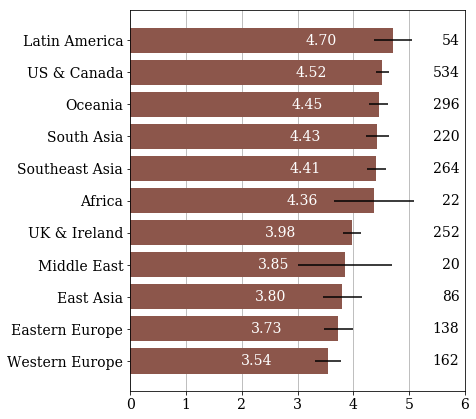

In [25]:
data = []
for region in df.region.unique():
    if not isinstance(region, str):
        continue
    stats = sms.DescrStatsW(df[df.region == region]['score'])
    data.append((region, stats.mean, stats.tconfint_mean(), stats.nobs))

fig = plt.figure(figsize=(6,7))
categories_chart(fig.gca(), data, 'C5')
fig.savefig('region.png', bbox_inches='tight')

In [26]:
treat_usca = Treatment(reference="US & Canada")  # make US & Canada the base category
model = sm.OLS.from_formula('score ~ C(region, treat_usca)', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     10.89
Date:                Thu, 21 Jun 2018   Prob (F-statistic):           2.99e-18
Time:                        16:58:11   Log-Likelihood:                -3683.0
No. Observations:                2048   AIC:                             7388.
Df Residuals:                    2037   BIC:                             7450.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   4.5206      0.063     71.288      0.000       4.396       4.645
C(region, treat_usca)[T.Africa]            -0.1570      0.319     -0.492      0.623      -0.782       0.468
C(region, treat_usca)[T.East Asia]         -0.7183      0.170     -4.219      0.000      -1.052      -0.384
C(region, treat_usca)[T.Eastern Europe]    -0.7887      0.140     -5.636      0.000      -1.063      -0.514
C(region, treat_usca)[T.Latin America]      0.1831      0.209      0.875      0.382      -0.227       0.593
C(region, treat_usca)[T.Middle East]       -0.6706      0.334     -2.009      0.045      -1.325      -0.016
C(region, treat_usca)[T.Oceania]           -0.0679      0.106     -0.639      0.523      -0.276       0.140
C(region, treat_usca)[T.South Asia]        -0.0933      0.117     -0.795      0.427      -0.324       0.137
C(region, treat_usca)[T.Southeast Asia]    -0.1077      0.110     -0.977      0.329      -0.324       0.108
C(region, treat_usca)[T.UK & Ireland]      -0.5444      0.112     -4.861      0.000      -0.764      -0.325
C(region, treat_usca)[T.Western Europe]    -0.9774      0.131     -7.436      0.000      -1.235      -0.720
==============================================================================
Omnibus:                        3.022   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                3.080
Skew:                           0.087   Prob(JB):                        0.214
Kurtosis:                       2.925   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Checking that all these regions have only statistically insignificant differences with the US & Canada
regions = ['US & Canada', 'Latin America', 'Oceania', 'South Asia', 'Southeast Asia', 'Africa']
model = sm.OLS.from_formula('score ~ region', data=df[df.region.isin(regions)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5529
Date:                Thu, 21 Jun 2018   Prob (F-statistic):              0.736
Time:                        16:58:11   Log-Likelihood:                -2493.1
No. Observations:                1390   AIC:                             4998.
Df Residuals:                    1384   BIC:                             5030.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.3636      0.311     14.041      0.000       3.754       4.973
region[T.Latin America]      0.3401      0.369      0.922      0.356      -0.383       1.063
region[T.Oceania]            0.0891      0.322      0.276      0.782      -0.543       0.721
region[T.South Asia]         0.0636      0.326      0.195      0.845      -0.576       0.703
region[T.Southeast Asia]     0.0492      0.323      0.152      0.879      -0.585       0.684
region[T.US & Canada]        0.1570      0.317      0.495      0.621      -0.465       0.779
==============================================================================
Omnibus:                        0.574   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.750   Jarque-Bera (JB):                0.580
Skew:                           0.050   Prob(JB):                        0.748
Kurtosis:                       2.986   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Score by background

This section compares the average scores of those who said they had particular backgrounds in debating.

Note that the column names don't actually mean what they say, they're just labels for brevity. They're actually stricter than the labels imply. The descriptors respondents were asked to apply are as follows, emphasis added:
- `none` means "I've never been involved in competitive debate _at the university level_."
- `current` means "I debate or judge in university-level debating tournaments (in any style/format)."
- `retiree` means "I used to debate or judge in _university-level_ debating tournaments (in any style/format), but have retired from both."
- `judge` means "I've _broken_ as an adjudicator at a _national or international British Parliamentary title tournament_, or Australs or UADC."
- `tabber` means "I've tabbed a _British Parliamentary_ tournament _with at least 50 teams_".

Note that the background categories aren't mutually exclusive, _e.g._, someone could be both a (breaking) `judge` and a `tabber`.

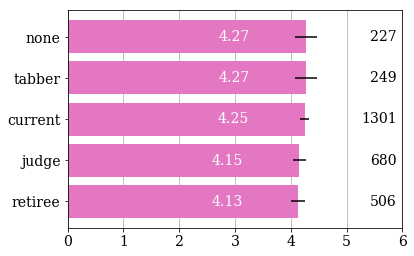

In [28]:
data = []
for field in ['none', 'current', 'retiree', 'judge', 'tabber']:
    if df[df[field]]['score'].count() < 15:
        continue
    stats = sms.DescrStatsW(df[df[field]]['score'])
    data.append((field, stats.mean, stats.tconfint_mean(), stats.nobs))

fig = plt.figure(figsize=(6,4))
categories_chart(fig.gca(), data, 'C6')

In [29]:
model = sm.OLS.from_formula('score ~ none + current + retiree + judge + tabber', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.986
Date:                Thu, 21 Jun 2018   Prob (F-statistic):             0.0776
Time:                        16:58:12   Log-Likelihood:                -3868.7
No. Observations:                2121   AIC:                             7749.
Df Residuals:                    2115   BIC:                             7783.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.4483      0.101     43.955      0.000       4.250       4.647
none[T.True]       -0.1444      0.132     -1.096      0.273      -0.403       0.114
current[T.True]    -0.1401      0.099     -1.421      0.155      -0.333       0.053
retiree[T.True]    -0.2527      0.107     -2.370      0.018      -0.462      -0.044
judge[T.True]      -0.1650      0.073     -2.247      0.025      -0.309      -0.021
tabber[T.True]      0.0858      0.104      0.828      0.408      -0.117       0.289
==============================================================================
Omnibus:                        3.906   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.636
Skew:                           0.055   Prob(JB):                        0.162
Kurtosis:                       2.829   Cond. No.                         7.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There's maybe a case to be made that judges and retirees were worse by a statistically significant difference, but it's not really convincing.

In [30]:
model = sm.OLS.from_formula('score ~ judge + retiree', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.571
Date:                Thu, 21 Jun 2018   Prob (F-statistic):             0.0283
Time:                        16:58:12   Log-Likelihood:                -3870.1
No. Observations:                2121   AIC:                             7746.
Df Residuals:                    2118   BIC:                             7763.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.3198      0.043     99.655      0.000       4.235       4.405
judge[T.True]      -0.1329      0.070     -1.901      0.057      -0.270       0.004
retiree[T.True]    -0.1403      0.077     -1.833      0.067      -0.290       0.010
==============================================================================
Omnibus:                        3.352   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                3.183
Skew:                           0.053   Prob(JB):                        0.204
Kurtosis:                       2.843   Cond. No.                         2.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model = sm.OLS.from_formula('score ~ tabber', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.08002
Date:                Thu, 21 Jun 2018   Prob (F-statistic):              0.777
Time:                        16:58:12   Log-Likelihood:                -3873.7
No. Observations:                2121   AIC:                             7751.
Df Residuals:                    2119   BIC:                             7763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.2404      0.035    122.017      0.000       4.172       4.309
tabber[T.True]     0.0287      0.101      0.283      0.777      -0.170       0.228
==============================================================================
Omnibus:                        3.415   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.249
Skew:                           0.055   Prob(JB):                        0.197
Kurtosis:                       2.844   Cond. No.                         3.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Questions by background

This code runs a logistic regression on whether answers to each question were correct, against respondents' answers to the background question.

As with the section just above, the column names don't actually mean what they say, they're just labels for brevity. Full descriptions are above.

If the log-likelihood ratio p-value is greater than 0.05, then there's no real difference between the categories, so it's no longer interested. If it's less than 0.05, it prints the whole model summary for perusal. This applies to two questions: (a) and (c). On further examination, there's a potentially significant coefficient (P>|z|) for tabbers in question (a) (a bit worse) and both non-debaters and breaking judges in (c) (again slightly worse). But because we're testing 50 hypotheses, I wouldn't read very much into a couple of apparently-significant differences.

In [32]:
for q in questions:
    model = sm.Logit.from_formula('%s_correct ~ none + current + retiree + judge + tabber' % q, data=df).fit(disp=False)
    p = model.llr_pvalue
    print("Question (%s): LLR p-value = %.4f" % (q, p))
    if p <= 0.05:
        display(model.summary())

Question (a): LLR p-value = 0.0036


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              a_correct   No. Observations:                 2121
Model:                          Logit   Df Residuals:                     2115
Method:                           MLE   Df Model:                            5
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                0.006167
Time:                        16:58:12   Log-Likelihood:                -1410.5
converged:                       True   LL-Null:                       -1419.2
                                        LLR p-value:                  0.003636
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5174      0.140     -3.695      0.000      -0.792      -0.243
none[T.True]        0.0525      0.181      0.290      0.772      -0.302       0.407
current[T.True]     0.2261      0.136      1.659      0.097      -0.041       0.493
retiree[T.True]    -0.1508      0.148     -1.017      0.309      -0.442       0.140
judge[T.True]      -0.0038      0.101     -0.038      0.970      -0.201       0.194
tabber[T.True]     -0.3212      0.147     -2.184      0.029      -0.609      -0.033
===================================================================================
"""

Question (b): LLR p-value = 0.2720
Question (c): LLR p-value = 0.0419


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              c_correct   No. Observations:                 2119
Model:                          Logit   Df Residuals:                     2113
Method:                           MLE   Df Model:                            5
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                0.004823
Time:                        16:58:12   Log-Likelihood:                -1189.4
converged:                       True   LL-Null:                       -1195.1
                                        LLR p-value:                   0.04186
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.3564      0.155      8.724      0.000       1.052       1.661
none[T.True]       -0.4240      0.196     -2.161      0.031      -0.809      -0.040
current[T.True]    -0.2339      0.151     -1.552      0.121      -0.529       0.061
retiree[T.True]     0.0195      0.165      0.118      0.906      -0.303       0.342
judge[T.True]      -0.2619      0.112     -2.346      0.019      -0.481      -0.043
tabber[T.True]      0.0793      0.161      0.492      0.623      -0.236       0.395
===================================================================================
"""

Question (d): LLR p-value = 0.3447
Question (e): LLR p-value = 0.2306
Question (f): LLR p-value = 0.8376
Question (g): LLR p-value = 0.4451
Question (h): LLR p-value = 0.9291
Question (i): LLR p-value = 0.1207
Question (j): LLR p-value = 0.1032


## Are countries better at deciphering themselves?
Not really, no.

`author_countries` are the countries the authors of the respective images, so image (a) was written by a Canadian, (b) by an American, and so on.

In [33]:
countries = ['United States', 'Canada', 'Mexico']
author_countries = ['Canada', 'United States', 'United States', 'United States', 'Canada', 
                    'Canada', 'United States', 'United States', 'United States', 'Mexico']
questions = 'abcdefghij'
for q, author_country in zip(questions, author_countries):
    model = sm.Logit.from_formula('%s_correct ~ C(country, Treatment(reference="%s"))' % (q, author_country),
                                        data=df[df.country.isin(countries)]).fit(disp=False)
    p = model.llr_pvalue
    print("Question (%s) (from %13s)  -  LLR p-value = %.4f" % (q, author_country, p))
    if p <= 0.05:
        display(model.summary())

Question (a) (from        Canada)  -  LLR p-value = 0.3205
Question (b) (from United States)  -  LLR p-value = 0.3175
Question (c) (from United States)  -  LLR p-value = 0.0413


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              c_correct   No. Observations:                  549
Model:                          Logit   Df Residuals:                      546
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                 0.01276
Time:                        16:58:12   Log-Likelihood:                -246.57
converged:                       True   LL-Null:                       -249.76
                                        LLR p-value:                   0.04126
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      1.7691      0.150     11.791      0.000       1.475       2.063
C(country, Treatment(reference="United States"))[T.Canada]    -0.3757      0.241     -1.558      0.119      -0.848       0.097
C(country, Treatment(reference="United States"))[T.Mexico]    -1.2582      0.538     -2.340      0.019      -2.312      -0.204
==============================================================================================================================
"""

Question (d) (from United States)  -  LLR p-value = 0.1579
Question (e) (from        Canada)  -  LLR p-value = 0.1435
Question (f) (from        Canada)  -  LLR p-value = 0.3387
Question (g) (from United States)  -  LLR p-value = 0.7331
Question (h) (from United States)  -  LLR p-value = 0.4353
Question (i) (from United States)  -  LLR p-value = 0.0571
Question (j) (from        Mexico)  -  LLR p-value = 0.0152


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              j_correct   No. Observations:                  550
Model:                          Logit   Df Residuals:                      547
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                 0.01126
Time:                        16:58:12   Log-Likelihood:                -367.90
converged:                       True   LL-Null:                       -372.09
                                        LLR p-value:                   0.01517
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      1.0986      0.577      1.903      0.057      -0.033       2.230
C(country, Treatment(reference="Mexico"))[T.Canada]           -1.0647      0.597     -1.785      0.074      -2.234       0.105
C(country, Treatment(reference="Mexico"))[T.United States]    -0.5893      0.588     -1.003      0.316      -1.741       0.562
==============================================================================================================================
"""